In [32]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import layers
from keras_tuner.tuners import BayesianOptimization
from tensorflow.python.keras.callbacks import EarlyStopping

In [22]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [33]:
# Load Data
real_data_path = r'C:\Users\Administrator\Desktop\training data\test\processed_data.csv'
aux_data_path = r'D:\二学位非软件文件\GREAT\dataset\processed_data.csv'

# Load the datasets
real_data = pd.read_csv(real_data_path)
aux_data = pd.read_csv(aux_data_path)

# Column labels
X_labels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
Y_labels = ["N", "Cab", "Ccx", "Canth", "Cm", "Cw", "Cp", "CBC"]

# Separate features and labels
X_real = real_data[X_labels].values
Y_real = real_data[Y_labels].values

X_aux = aux_data[X_labels].values
Y_aux = aux_data[Y_labels].values

# Replace NaN values with 0 in Y_aux
Y_aux_filled = np.nan_to_num(Y_aux, nan=0.0)

In [34]:
Y_real

array([[1.90290558e+00, 5.43951803e+01, 1.01858921e+01, ...,
        1.42941180e-02, 1.42979600e-03, 6.19149500e-03],
       [1.80871659e+00, 5.28239484e+01, 1.36557760e+01, ...,
        1.34574780e-02, 1.24792300e-03, 5.17690500e-03],
       [1.84572733e+00, 5.71453714e+01, 1.10284767e+01, ...,
        1.17108120e-02, 1.28222500e-03, 5.44889100e-03],
       ...,
       [2.69461221e+00, 4.44604841e+01, 8.89680790e+00, ...,
        7.75109600e-03, 9.83420000e-04, 5.13598400e-03],
       [2.02924315e+00, 3.55345451e+01, 7.06861164e+00, ...,
        9.91216000e-03, 6.38103000e-04, 4.52748400e-03],
       [2.38563405e+00, 4.04578762e+01, 7.72907714e+00, ...,
        8.03137300e-03, 9.74367000e-04, 5.28388100e-03]])

In [35]:
X_real

array([[0.05351786, 0.06964819, 0.127486  , ..., 0.52140686, 0.302476  ,
        0.14440936],
       [0.03467714, 0.04758087, 0.1103664 , ..., 0.51815529, 0.319096  ,
        0.15762082],
       [0.04825238, 0.06179565, 0.115302  , ..., 0.52533431, 0.32171667,
        0.16340091],
       ...,
       [0.08242262, 0.10526486, 0.19143   , ..., 0.59981961, 0.433432  ,
        0.2675363 ],
       [0.08344   , 0.10431043, 0.1831952 , ..., 0.54321294, 0.3546344 ,
        0.20191534],
       [0.08402738, 0.10653732, 0.18900533, ..., 0.57178039, 0.39990667,
        0.2381258 ]])

In [36]:
Y_aux
# Replace NaN values with 0 in Y_aux

array([[1.31359402e+00, 1.25407820e+01, 4.33000000e+00, ...,
        1.22231000e-02,            nan,            nan],
       [1.31359402e+00, 1.25407820e+01, 4.33000000e+00, ...,
        1.22231000e-02,            nan,            nan],
       [1.42578515e+00, 1.24136890e+01, 3.65000000e+00, ...,
        1.20002800e-02,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [37]:
Y_aux_filled

array([[1.31359402e+00, 1.25407820e+01, 4.33000000e+00, ...,
        1.22231000e-02, 0.00000000e+00, 0.00000000e+00],
       [1.31359402e+00, 1.25407820e+01, 4.33000000e+00, ...,
        1.22231000e-02, 0.00000000e+00, 0.00000000e+00],
       [1.42578515e+00, 1.24136890e+01, 3.65000000e+00, ...,
        1.20002800e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [38]:
# Create a mask for non-NaN values in the original Y_aux
mask_Y_aux = ~np.isnan(Y_aux)

# Data Preprocessing
scaler_X = StandardScaler().fit(X_real)
scaler_Y = StandardScaler().fit(Y_real)

X_real_scaled = scaler_X.transform(X_real)
Y_real_scaled = scaler_Y.transform(Y_real)

X_aux_scaled = scaler_X.transform(X_aux)
Y_aux_scaled = scaler_Y.transform(Y_aux_filled)

# Combine Data
real_ratio = 0.7
aux_ratio = 0.3

X_combined = np.vstack([X_real_scaled * real_ratio, X_aux_scaled * aux_ratio])
Y_combined = np.vstack([Y_real_scaled * real_ratio, Y_aux_scaled * aux_ratio])
mask_combined = np.vstack([np.ones_like(Y_real_scaled, dtype=bool) * real_ratio, mask_Y_aux * aux_ratio])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)
_, _, mask_train, mask_test = train_test_split(X_combined, mask_combined, test_size=0.2, random_state=42)

In [39]:
print(np.isnan(X_real_scaled).any())
print(np.isnan(Y_real_scaled).any())
print(np.isnan(X_aux_scaled).any())
print(np.isnan(Y_aux_scaled).any())
print(np.isnan(X_combined).any())
print(np.isnan(Y_combined).any())

False
False
False
False
False
False


In [40]:
# Custom Loss Function
def custom_loss(y_true, y_pred):
    mse_loss = tf.square(y_true - y_pred)
    masked_mse_loss = tf.where(mask_train, mse_loss, 0.0)
    loss = tf.reduce_sum(masked_mse_loss, axis=-1)
    return loss

# Build Model
def build_model(hp):
    input_features = layers.Input(shape=(X_train.shape[1],), name='input_features')
    
    x = input_features
    for i in range(hp.Int("num_layers", 2, 12)):
        x = layers.Dense(units=hp.Int("units_" + str(i), 32, 512, step=16), activation="relu")(x)
        x = layers.Dropout(hp.Float("dropout", 0.05, 0.5, step=0.05))(x)
    
    output = layers.Dense(len(Y_labels))(x)
    
    model = tf.keras.Model(inputs=input_features, outputs=output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")),
                  loss=custom_loss,
                  metrics=["mae"])
    
    return model

# Hyperparameter Tuning
early_stopping = EarlyStopping(monitor='val_mae', patience=7, restore_best_weights=True)

tuner = BayesianOptimization(
    build_model,
    objective="val_mae",
    max_trials=20,
    num_initial_points=10,
    directory="keras_tuner_directory",
    project_name="ann_tuning_bayesian_optimized_v3"
)

AttributeError: 'KerasTensor' object has no attribute 'node'

In [19]:
# Training the model
tuner.search(X_train, y_train, epochs=120, validation_split=0.2, callbacks=[early_stopping])

Trial 2 Complete [00h 00m 14s]
val_mae: nan

Best val_mae So Far: nan
Total elapsed time: 00h 00m 21s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
11                |4                 |num_layers
432               |112               |units_0
0.1               |0.4               |dropout
256               |480               |units_1
0.001291          |0.00069676        |learning_rate
48                |32                |units_2
480               |32                |units_3
192               |None              |units_4
496               |None              |units_5
448               |None              |units_6
368               |None              |units_7
448               |None              |units_8
352               |None              |units_9
480               |None              |units_10
32                |None              |units_11
Epoch 1/120
139/139 [==============================] - 3s 14ms/step - loss: nan - mae: nan - val_loss: nan - val_mae:

TypeError: can only concatenate str (not "NoneType") to str

In [8]:
# Get the Best Model and Fine-tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Fine-tuning with combined data
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Evaluate Model
loss, mae = best_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

predictions = best_model.predict(X_test)
errors = predictions - y_test

# 均方误差 (MSE) 和 均方根误差 (RMSE):
# 这两种指标在回归任务中很常见。RMSE 会放大大的误差，因此它对异常值更敏感。如果RMSE的值较大，这意味着模型预测存在较大的误差。
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, RMSE: {rmse}')

# 绝对百分比误差 (MAPE):
# MAPE表示预测误差与真实值的比例。它可以帮助你了解模型预测误差相对于真实值的大小。
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'MAPE: {mape}%')

# R-squared (R²)
# R²是决定系数，表示模型预测的变异与总变异的比例。值为1表示模型预测完美，值为0表示模型的预测与平均值没有区别。
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f'R²: {r2}')

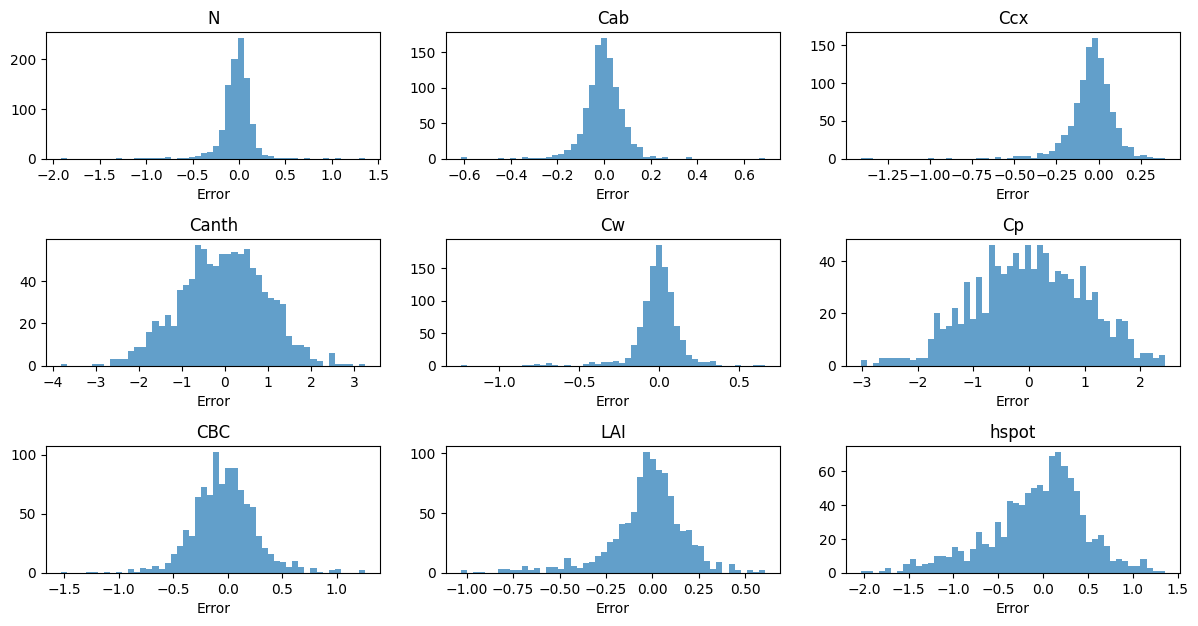

In [12]:
# 6. 绘制误差图
plt.figure(figsize=(12, 8))
for i, label in enumerate(Y_labels):
    plt.subplot(4, 3, i+1)
    plt.hist(errors[:, i], bins=50, alpha=0.7)
    plt.title(label)
    plt.xlabel("Error")
plt.tight_layout()
plt.show()

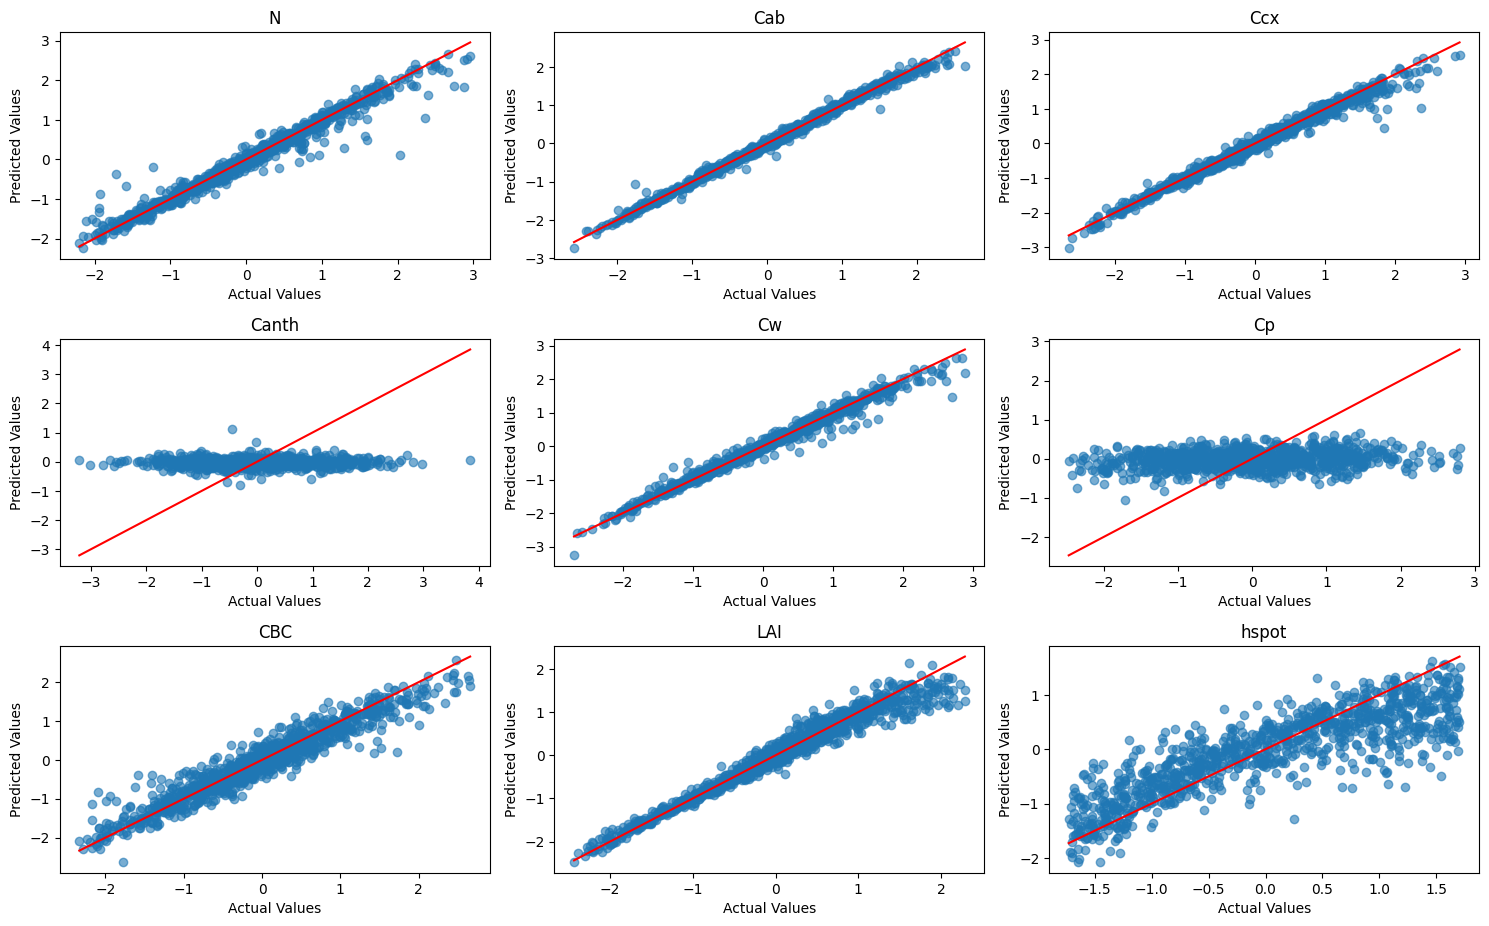

In [13]:
#散点图
plt.figure(figsize=(15, 12))
for i, label in enumerate(Y_labels):
    plt.subplot(4, 3, i+1)
    plt.scatter(y_test[:, i], predictions[:, i], alpha=0.6)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r')
    plt.title(label)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()

In [14]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 12)               0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 224)              2912      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 224)              0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 288)              64800     
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 288)              0

In [15]:
# 保存模型
best_model.save(r"C:\Users\Administrator\Desktop\training data\model\model")
# 保存数据预处理器
joblib.dump(scaler_X, r"C:\Users\Administrator\Desktop\training data\model\scaler_X.pkl")
joblib.dump(scaler_Y, r"C:\Users\Administrator\Desktop\training data\model\scaler_y.pkl")

INFO:tensorflow:Assets written to: C:\Users\Administrator\Desktop\training data\model\model\assets


INFO:tensorflow:Assets written to: C:\Users\Administrator\Desktop\training data\model\model\assets


['C:\\Users\\Administrator\\Desktop\\training data\\model\\scaler_y.pkl']